In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
import torchvision.transforms as transforms
from PIL import Image
import d2l_torch as d2l
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
import torch.optim as optim
import sys

import pandas as pd
import os
from gensim.models import word2vec
import torch
from torch.utils import data
from torch import nn
from gensim.models import Word2Vec

In [2]:
home_dir = '../data/kaggle_bag/'
path_prefix = "../data/kaggle_bag/save/"

train = pd.read_csv(os.path.join(home_dir,'labeledTrainData.tsv.zip'), header=0, delimiter="\t", quoting=3)
test = pd.read_csv(os.path.join(home_dir,'testData.tsv.zip'), header=0, delimiter="\t", quoting=3)
unlabeled_train = pd.read_csv(os.path.join(home_dir,'unlabeledTrainData.tsv.zip'), header=0, delimiter="\t", quoting=3)

In [3]:
label_train_path = "labeledTrainData.tsv"
unlabel_train_path = "unlabeledTrainData.tsv"
test_path = "testData.tsv"

In [4]:
def load_training_data(path='labeledTrainData.tsv'):  
    #global x,y
    # 把training時需要的data讀進來
    # 如果是'training_labe|l.txt'，需要讀取label，如果是'training_nolabel.txt'，不需要讀取label
    if(path == "labeledTrainData.tsv"):
        df = pd.read_csv(os.path.join(home_dir, 'labeledTrainData.tsv.zip'),sep = "\t")
        #display(df.head())
        x = df['review'].apply(lambda x: x.strip().split(" "))
        x = list(x)
        y = df["sentiment"]  #二维的list
        y = list(y)   #一维的list
        return x, y
    else:
        df = pd.read_csv(os.path.join(home_dir, 'unlabeledTrainData.tsv.zip'),sep = "\t",error_bad_lines=False)
        x = df['review'].apply(lambda x: x.strip().split(" "))
        x = list(x)
        return x
    

def load_testing_data(path='testData.tsv'):   #约55万
    # 把testing時需要的data讀進來
    df = pd.read_csv(os.path.join(home_dir, 'testData.tsv.zip'),sep = "\t")
    #display(df.head())
    x = df['review'].apply(lambda x: x.strip().split(" "))
    x = list(x)
    return x  # X形如[["i","am","here"], ["he","loves","it"]]


def evaluation(outputs, labels):
    #outputs => probability (float)
    #labels => labels
    outputs[outputs>=0.5] = 1 # 大於等於0.5為有惡意
    outputs[outputs<0.5] = 0 # 小於0.5為無惡意
    correct = torch.sum(torch.eq(outputs, labels)).item()
    return correct

In [5]:
train_x, y = load_training_data(label_train_path)
average_sentence_length = 0
for sen in train_x:
    average_sentence_length += len(sen)
average_sentence_length /= len(train_x)
print("训练集平均句子长度：",average_sentence_length)

训练集平均句子长度： 233.78624


In [6]:
def train_word2vec(x):
    # 訓練word to vector 的 word embedding
    model = word2vec.Word2Vec(x, vector_size=250, window=5, min_count=5, workers=0, epochs=10, sg=1)
    return model

In [7]:
# print("loading training data ...")
# train_x, y = load_training_data(label_train_path)
# train_x_no_label = load_training_data(unlabel_train_path)

# print("loading testing data ...")
# test_x = load_testing_data(test_path)

# model = train_word2vec(train_x + train_x_no_label + test_x)

# print("saving model ...")
# # model.save(os.path.join(path_prefix, 'model/w2v_all.model'))
# model.save(os.path.join(path_prefix, 'w2v_all.model'))
# print("saving model complished")

loading training data ...


b'Skipping line 43043: expected 2 fields, saw 3\n'


loading testing data ...
saving model ...
saving model complished


In [8]:
class Preprocess():
    def __init__(self, sentences, sen_len, w2v_path="./w2v.model"):
        self.w2v_path = w2v_path
        self.sentences = sentences
        self.sen_len = sen_len
        self.idx2word = []
        self.word2idx = {}
        self.embedding_matrix = []
    def get_w2v_model(self):
        # 把之前訓練好的word to vec 模型讀進來
        self.embedding = Word2Vec.load(self.w2v_path)
        self.embedding_dim = self.embedding.vector_size
    def add_embedding(self, word):
        # 把word加進embedding，並賦予他一個隨機生成的representation vector
        # word只會是"<PAD>"或"<UNK>"
        vector = torch.empty(1, self.embedding_dim)
        torch.nn.init.uniform_(vector)
        self.word2idx[word] = len(self.word2idx)
        self.idx2word.append(word)
        self.embedding_matrix = torch.cat([self.embedding_matrix, vector], 0)
    def make_embedding(self, load=True):
        print("Get embedding ...")
        # 取得訓練好的 Word2vec word embedding
        if load:
            print("loading word to vec model ...")
            self.get_w2v_model()
        else:
            raise NotImplementedError
        # 製作一個 word2idx 的 dictionary
        # 製作一個 idx2word 的 list
        # 製作一個 word2vector 的 list
        for i, word in enumerate(self.embedding.wv.index_to_key):
            print('get words #{}'.format(i+1), end='\r')
            #e.g. self.word2index['魯'] = 1 
            #e.g. self.index2word[1] = '魯'
            #e.g. self.vectors[1] = '魯' vector
            self.word2idx[word] = len(self.word2idx)
            self.idx2word.append(word)
            self.embedding_matrix.append(self.embedding.wv[word])
        print('')
        self.embedding_matrix = torch.tensor(self.embedding_matrix)
        # 將"<PAD>"跟"<UNK>"加進embedding裡面
        self.add_embedding("<PAD>")
        self.add_embedding("<UNK>")
        print("total words: {}".format(len(self.embedding_matrix)))
        return self.embedding_matrix
    def pad_sequence(self, sentence):
        # 將每個句子變成一樣的長度
        if len(sentence) > self.sen_len:
            sentence = sentence[:self.sen_len]
        else:
            pad_len = self.sen_len - len(sentence)
            for _ in range(pad_len):
                sentence.append(self.word2idx["<PAD>"])
        assert len(sentence) == self.sen_len
        return sentence
    def sentence_word2idx(self):
        # 把句子裡面的字轉成相對應的index
        sentence_list = []
        for i, sen in enumerate(self.sentences):
            print('sentence count #{}'.format(i+1), end='\r')
            sentence_idx = []
            for word in sen:
                if (word in self.word2idx.keys()):
                    sentence_idx.append(self.word2idx[word])
                else:
                    sentence_idx.append(self.word2idx["<UNK>"])
            # 將每個句子變成一樣的長度
            sentence_idx = self.pad_sequence(sentence_idx)
            sentence_list.append(sentence_idx)
        return torch.LongTensor(sentence_list)
    def labels_to_tensor(self, y):
        # 把labels轉成tensor
        y = [int(label) for label in y]
        
        return torch.LongTensor(y)

In [9]:
class SentimentDataset(data.Dataset):
    """
    Expected data shape like:(data_num, data_len)
    Data can be a list of numpy array or a list of lists
    input data shape : (data_num, seq_len, feature_dim)
    
    __len__ will return the number of data
    """
    def __init__(self, X, y):
        self.data = X
        self.label = y
    def __getitem__(self, idx):
        if self.label is None: return self.data[idx]
        return self.data[idx], self.label[idx]
    def __len__(self):
        return len(self.data)

In [10]:
class LSTM_Net(nn.Module):
    def __init__(self, embedding, embedding_dim, hidden_dim, num_layers, dropout=0.5, fix_embedding=True):
        super(LSTM_Net, self).__init__()
        # 製作 embedding layer
        self.embedding = torch.nn.Embedding(embedding.size(0),embedding.size(1))
        self.embedding.weight = torch.nn.Parameter(embedding)
        # 是否將 embedding fix住，如果fix_embedding為False，在訓練過程中，embedding也會跟著被訓練
        self.embedding.weight.requires_grad = False if fix_embedding else True
        self.embedding_dim = embedding.size(1)
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = dropout
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.classifier = nn.Sequential( nn.Dropout(dropout),
                                         nn.Linear(hidden_dim, 1),
                                         nn.Sigmoid() )
    def forward(self, inputs):
        inputs = self.embedding(inputs)
        x, _ = self.lstm(inputs, None)
        # x 的 dimension (batch, seq_len, hidden_size)
        # 取用 LSTM 最後一層的 hidden state
        x = x[:, -1, :] 
        x = self.classifier(x)
        return x

In [20]:
yy_train_loss=[]
yy_valid_loss = []
yy_train_acc = []
yy_valid_acc = []
xx = []
early_stopping_epoch = 30
add_num = 0
total_loss, total_acc = 0,0
best_acc = 0
pre_valid_loss = 100000

def training(batch_size, n_epoch, lr, model_dir, train, valid, model, device):
    global add_num,total_loss,total_acc,best_acc,pre_valid_loss
    
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('\nstart training, parameter total:{}, trainable:{}\n'.format(total, trainable))
    model.train() # 將model的模式設為train，這樣optimizer就可以更新model的參數
    criterion = nn.BCELoss() # 定義損失函數，這裡我們使用binary cross entropy loss
    t_batch = len(train) 
    v_batch = len(valid) 
    optimizer = optim.Adam(model.parameters(), lr=lr)
    #optimizer = optim.SGD(model.parameters(), lr=lr, momentum = 0.9) # 將模型的參數給optimizer，並給予適當的learning rate
    total_loss, total_acc, best_acc = 0, 0, 0
    for epoch in range(n_epoch):
        xx.append(epoch)
        
        total_loss, total_acc = 0, 0
        # 這段做training
        for i, (inputs, labels) in enumerate(train):
            inputs = inputs.to(device, dtype=torch.long) # device為"cuda"，將inputs轉成torch.cuda.LongTensor
            labels = labels.to(device, dtype=torch.float) # device為"cuda"，將labels轉成torch.cuda.FloatTensor，因為等等要餵進criterion，所以型態要是float
            optimizer.zero_grad() # 由於loss.backward()的gradient會累加，所以每次餵完一個batch後需要歸零
            outputs = model(inputs) # 將input餵給模型
            outputs = outputs.squeeze() # 去掉最外面的dimension，好讓outputs可以餵進criterion()
            loss = criterion(outputs, labels) # 計算此時模型的training loss
            loss.backward() # 算loss的gradient
            optimizer.step() # 更新訓練模型的參數
            correct = evaluation(outputs, labels) # 計算此時模型的training accuracy
            total_acc += (correct / batch_size)
            total_loss += loss.item()
            print('[ Epoch{}: {}/{} ] loss:{:.3f} acc:{:.3f} '.format(
            	epoch+1, i+1, t_batch, loss.item(), correct*100/batch_size), end='\r')
        print('\nTrain | Loss:{:.5f} Acc: {:.3f}'.format(total_loss/t_batch, total_acc/t_batch*100))
        yy_train_loss.append(total_loss/t_batch)
        yy_train_acc.append(total_acc/t_batch*100)
        
        
        # 這段做validation
        model.eval() # 將model的模式設為eval，這樣model的參數就會固定住
        with torch.no_grad():
            total_loss, total_acc = 0, 0
            for i, (inputs, labels) in enumerate(valid):
                inputs = inputs.to(device, dtype=torch.long) # device為"cuda"，將inputs轉成torch.cuda.LongTensor
                labels = labels.to(device, dtype=torch.float) # device為"cuda"，將labels轉成torch.cuda.FloatTensor，因為等等要餵進criterion，所以型態要是float
                outputs = model(inputs) # 將input餵給模型
                outputs = outputs.squeeze() # 去掉最外面的dimension，好讓outputs可以餵進criterion()
                loss = criterion(outputs, labels) # 計算此時模型的validation loss
                correct = evaluation(outputs, labels) # 計算此時模型的validation accuracy
                total_acc += (correct / batch_size)
                total_loss += loss.item()

            print("Valid | Loss:{:.5f} Acc: {:.3f} ".format(total_loss/v_batch, total_acc/v_batch*100))
            yy_valid_loss.append(total_loss/v_batch)
            yy_valid_acc.append(total_acc/v_batch*100)
            
            # early stopping,连续增长到early_stopping_epoch轮数的话，就会提前终止epoch循环,epoch = sys.maxsize
            curr_valid_loss = total_loss/v_batch
            
            if(curr_valid_loss > pre_valid_loss):
                add_num += 1
                if(add_num == early_stopping_epoch):
                    epoch = sys.maxsize
            else:
                add_num = 0
                
            pre_valid_loss = curr_valid_loss
            
                        
            if total_acc/v_batch > best_acc:
                print("total_acc/v_batch:",total_acc/v_batch)
                
                # 如果validation的結果優於之前所有的結果，就把當下的模型存下來以備之後做預測時使用
                best_acc = total_acc/v_batch
                
                
                #torch.save(model, "{}/val_acc_{:.3f}.model".format(model_dir,total_acc/v_batch*100))
                dr = "{}/ckpt.model".format(model_dir)
                print(dr)
                torch.save(model, "{}/ckpt.model".format(model_dir))
                print('saving model with acc {:.3f}'.format(total_acc/v_batch*100))
        print('-----------------------------------------------')
        model.train() # 將model的模式設為train，這樣optimizer就可以更新model的參數（因為剛剛轉成eval模式）
    #结束for循环
    
    #将最好的valid的best_acc存放下来
    tt_path = os.path.join(path_prefix, str(best_acc) +"_best_acc.txt")
    # tt_path = str(best_acc) +"_best_acc.txt"
    with open(tt_path,"w") as f:
        f.write(str(best_acc))
    
    
    ax1 = plt.subplot(1,2,1)
    plt.sca(ax1)
    # print('xx:', len(xx))
    # print('xx:', type(xx))
    plt.plot(xx,yy_train_loss,"r",label = "train_loss")
    plt.plot(xx,yy_valid_loss,"b",label = "valid_loss")
    plt.legend()
    ax2 = plt.subplot(1,2,2)
    plt.sca(ax2)
    plt.plot(xx,yy_train_acc,"y",label = "train_acc")
    plt.plot(xx,yy_valid_acc,"g",label = "valid_acc")
    plt.legend()
    
    print("over")

In [12]:
def testing(batch_size, test_loader, model, device):
    model.eval()
    ret_output = []
    with torch.no_grad():
        for i, inputs in enumerate(test_loader):
            inputs = inputs.to(device, dtype=torch.long)
            outputs = model(inputs)
            outputs = outputs.squeeze()
            #outputs[outputs>=0.5] = 1 # 大於等於0.5為負面
            #outputs[outputs<0.5] = 0 # 小於0.5為正面
            ret_output += outputs.float().tolist()
    
    return ret_output

loading data ...
Get embedding ...
loading word to vec model ...
get words #121343
total words: 121345
sentence count #25000
start training, parameter total:30838501, trainable:502251

[ Epoch1: 157/157 ] loss:0.711 acc:9.375  
Train | Loss:0.69555 Acc: 49.861
Valid | Loss:0.69332 Acc: 48.281 
total_acc/v_batch: 0.4828125
../data/kaggle_bag/save//ckpt.model
saving model with acc 48.281
-----------------------------------------------
[ Epoch2: 157/157 ] loss:0.692 acc:14.844 
Train | Loss:0.69392 Acc: 50.065
Valid | Loss:0.69302 Acc: 48.457 
total_acc/v_batch: 0.4845703125
../data/kaggle_bag/save//ckpt.model
saving model with acc 48.457
-----------------------------------------------
[ Epoch3: 157/157 ] loss:0.695 acc:15.625 
Train | Loss:0.69348 Acc: 50.433
Valid | Loss:0.69287 Acc: 49.805 
total_acc/v_batch: 0.498046875
../data/kaggle_bag/save//ckpt.model
saving model with acc 49.805
-----------------------------------------------
[ Epoch4: 157/157 ] loss:0.692 acc:15.625 
Train | Los

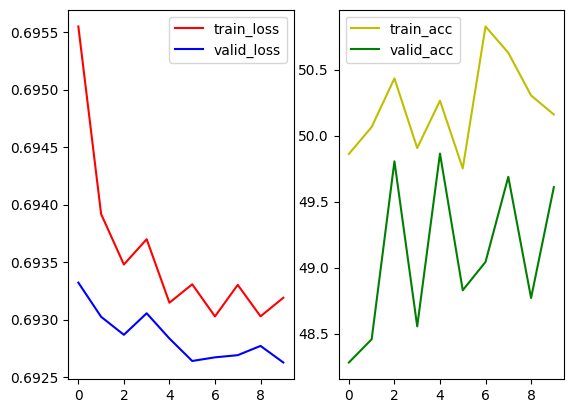

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 處理好各個data的路徑

#  label_train_path = "labeledTrainData.tsv"
#  unlabel_train_path = "unlabeledTrainData.tsv"
#  test_path = "testData.tsv"
train_with_label = os.path.join(path_prefix, label_train_path)
train_no_label = os.path.join(path_prefix, unlabel_train_path)
testing_data = os.path.join(path_prefix, test_path)

w2v_path = os.path.join(path_prefix, 'w2v_all.model') # 處理word to vec model的路徑

# 定義句子長度、要不要固定embedding、batch大小、要訓練幾個epoch、learning rate的值、model的資料夾路徑
sen_len = 200
fix_embedding = True # fix embedding during training
batch_size = 128
epoch = 10
lr = 0.001
# model_dir = os.path.join(path_prefix, 'model/') # model directory for checkpoint model
model_dir = path_prefix # model directory for checkpoint model

print("loading data ...") # 把'training_label.txt'跟'training_nolabel.txt'讀進來
train_x, y = load_training_data(label_train_path)
#train_x_no_label = load_training_data(train_no_label)

# 對input跟labels做預處理
preprocess = Preprocess(train_x, sen_len, w2v_path=w2v_path)
embedding = preprocess.make_embedding(load=True)
train_x = preprocess.sentence_word2idx()
y = preprocess.labels_to_tensor(y)

# 製作一個model的對象
model = LSTM_Net(embedding, embedding_dim=250, hidden_dim=250, num_layers=1, dropout=0.5, fix_embedding=fix_embedding)
model = model.to(device) # device為"cuda"，model使用GPU來訓練(餵進去的inputs也需要是cuda tensor)

# 把data分為training data跟validation data(將一部份training data拿去當作validation data)
p = 0.8
split_num = int(len(train_x)*p)
X_train, X_val, y_train, y_val = train_x[:split_num], train_x[split_num:], y[:split_num], y[split_num:]

# 把data做成dataset供dataloader取用
train_dataset = SentimentDataset(X=X_train, y=y_train)
val_dataset = SentimentDataset(X=X_val, y=y_val)

# 把data 轉成 batch of tensors
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = batch_size,
                                            shuffle = True,
                                            num_workers = 0)

val_loader = torch.utils.data.DataLoader(dataset = val_dataset,
                                            batch_size = batch_size,
                                            shuffle = False,
                                            num_workers = 0)

# 開始訓練
training(batch_size, epoch, lr, model_dir, train_loader, val_loader, model, device)

In [ ]:
fig=plt.figure(figsize=(20,7))
ax1 = plt.subplot(1,2,1)
plt.sca(ax1)
plt.plot(xx,yy_train_loss,"r",label = "train_loss")
plt.plot(xx,yy_valid_loss,"b",label = "valid_loss")
plt.legend()
ax2 = plt.subplot(1,2,2)
plt.sca(ax2)
plt.plot(xx,yy_train_acc,"y",label = "train_acc")
plt.plot(xx,yy_valid_acc,"g",label = "valid_acc")
plt.legend()

plt.savefig(os.path.join(path_prefix, 'Adam_lr0.001_200epoch.png'))
print("over")

In [ ]:
# 開始測試模型並做預測
print("loading testing data ...")
test_x = load_testing_data(testing_data)
preprocess = Preprocess(test_x, sen_len, w2v_path=w2v_path)
embedding = preprocess.make_embedding(load=True)
test_x = preprocess.sentence_word2idx()
test_dataset = SentimentDataset(X=test_x, y=None)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                            batch_size = batch_size,
                                            shuffle = False,
                                            num_workers = 8)
print('\nload model ...')
model = torch.load(os.path.join(model_dir, 'ckpt.model'))
outputs = testing(batch_size, test_loader, model, device)


# 以下是使用command line上傳到kaggle的方式
# 需要先pip install kaggle、Create API Token，詳細請看https://github.com/Kaggle/kaggle-api以及https://www.kaggle.com/code1110/how-to-submit-from-google-colab
# kaggle competitions submit [competition-name] -f [csv file path]] -m [message]
# ex: kaggle competitions submit ml-2020spring-hw4 -f output/predict.csv -m "......"

In [ ]:
df = pd.read_csv(os.path.join(home_dir, 'testData.tsv.zip'),sep = "\t"')
kk = list(df["id"])


# 寫到csv檔案供上傳kaggle
submission = pd.DataFrame({"id":kk,"sentiment":outputs})

submission.loc[submission['sentiment'] < 0.5, 'sentiment'] = 0 
submission.loc[submission['sentiment'] != 0, 'sentiment'] = 1 
submission.to_csv(os.path.join(path_prefix, 'submission.csv') , index = False) #accuracy 0.97604

print("Finish Predicting")

In [ ]:
def train_main(net, train_iter, test_iter, num_epochs, lr, num_gpus, out_dir):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

    def accuracy(y_hat, y):
        return (y_hat.argmax(1) == y).sum()

    model_path = os.path.join(out_dir, 'cifar_%s.pth' % (num_epochs))
    result_csv_path = os.path.join(out_dir, 'train_detail_%s.csv' % num_epochs)
    print('model_path:', model_path)
    print('result_csv_path:', result_csv_path)
    net.apply(init_weights)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    print(devices)
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    #     trainer = torch.optim.SGD(net.parameters(), lr)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    train_detail = pd.DataFrame(columns=['train_loss', 'test_loss', 'train acc', 'test acc'])
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train_loss', 'test_loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_loss_tot, train_acc_tot, train_tot = 0, 0, 0
        test_loss_tot, test_acc_tot, test_tot = 0, 0, 0
        net.train()
        for X, y in train_iter:
            optimizer.zero_grad()
            X, y = X.to(devices[0]), y.to(devices[0])
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                train_loss_tot += l * X.shape[0]
                train_acc_tot += accuracy(y_hat, y)
                train_tot += X.shape[0]
        net.eval()
        with torch.no_grad():
            for X, y in test_iter:
                X, y = X.to(devices[0]), y.to(devices[0])
                y_hat = net(X)
                test_loss_tot += l * X.shape[0]
                test_acc_tot += accuracy(y_hat, y)
                test_tot += X.shape[0]
        train_loss = train_loss_tot / train_tot
        train_acc = train_acc_tot / train_tot
        test_acc = test_acc_tot / test_tot
        test_loss = test_loss_tot / test_tot
        animator.add(epoch + 1, (train_loss.cpu(), test_loss.cpu(), train_acc.cpu(), test_acc.cpu()))
        train_detail.loc[len(train_detail)] = [train_loss.cpu(), test_loss.cpu(), train_acc.cpu(), test_acc.cpu()]
        # print('train_loss:', train_loss, '\ttrain_acc', test_acc, '\ttest_acc', test_acc)
        torch.save(net.state_dict(), model_path)
        train_detail.to_csv(result_csv_path, index=False)

In [ ]:
# train_slices = random.sample(list(range(n_train)), 15000)
# test_slices = list(set(range(n_train)) - set(train_slices))
# EPOCHS = 100

# _train_iter = load_data(train_images[train_slices], train_labels[train_slices], 256, train=True)
# _test_iter = load_data(train_images[test_slices], train_labels[test_slices], 256, train=False)
# out_dir = '../data/kaggle_leaves/classify-leaves/save/'
# # 训练。
# train_main(torchvision.models.resnet18(num_classes=176), _train_iter, _test_iter, EPOCHS, 0.0001,
#            1, out_dir)

In [ ]:
def predict(pred_iter):
    devices = [d2l.try_gpu(i) for i in range(1)]
    print(devices)
    net = torchvision.models.resnet18(num_classes=176)
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    net.load_state_dict(torch.load('../data/kaggle_leaves/classify-leaves/save/cifar_100.pth'))
    model = net.to('cuda:0')
    model.eval()  # 设置模型为推理模式
    # leaves_resnet_jupyter_baba_100
    net.to(torch.device('cuda:0'))
    net.eval()
    prediction = []
    for index, X in enumerate(pred_iter):
        X = X.to('cuda:0')
        prediction.extend(train_labels_header[net(X).argmax(1).cpu()])
    test_data['label'] = prediction
    test_data.to_csv('../data/kaggle_leaves/classify-leaves/save/submission.csv', index=None)

In [ ]:
# predict(pred_iter=load_data(pred_images, None, 256, train=False))